In [1]:
# General imports
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 7)  # make the default figure size larger
matplotlib.rcParams['image.interpolation'] = 'nearest'  # don't blur/smooth image plots
from astropy.io import fits
from astropy.table import Table

# model STARs - WebbPSF
import webbpsf
import webbpsf.roman

# model GALAXY - 2D Gaussian
from astropy.modeling.functional_models import Gaussian2D as gauss

# Pysynphot
import pysynphot as S

# Grizli
import grizli
from grizli.model import GrismFLT

######## Setup environment

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/")

root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
ready_direct = f"ready_direct_{root}"
empty_seg = "empty_seg.fits"
empty_direct = "empty_direct.fits"

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# Model an object
x_stddev = 3    # pix
y_stddev = 3    # pix
x_0 = 2044      # pix ; x & y center must be entered backwards
y_0 = 2044      # pix
amplitude = 10  # value/counts
theta = np.pi/2 #radians

args = (amplitude, x_0, y_0, x_stddev, y_stddev, theta)

model_galaxy = np.fromfunction(lambda i,j: gauss.evaluate(i, j, *args), shape=(4088,4088))

In [3]:
# Model object much bigger for seg map
x_stddev = 30   # pix
y_stddev = 30   # pix
x_0 = 2044      # pix ; x & y center must be entered backwards
y_0 = 2044      # pix
amplitude = 10  # value/counts
theta = np.pi/2 #radians

args = (amplitude, x_0, y_0, x_stddev, y_stddev, theta)

seg_model = np.fromfunction(lambda i,j: gauss.evaluate(i, j, *args), shape=(4088,4088))

In [4]:
# Choose/Select files and variables
SPECTEMP = 4
mag = 10

##########
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Read in spectrum
sed_path = os.path.join(SED_dir, f"SED:rest:gal.{SPECTEMP}.fits")
spectrum = Table.read(sed_path, format="fits")
wave = spectrum["wavelength"]
flux = spectrum["flux"]
z = (10000 / wave.min()) - 1

spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam").redshift(z)
spec = spec.renorm(mag, "abmag", bp)
spec.convert("flam")

In [5]:
# Instantiate
pad = 100
roman_sim = GrismFLT(direct_file=empty_direct, seg_file=empty_seg, pad=pad)

# Set direct image and seg map
roman_sim.direct.data["SCI"] = np.rot90(model_galaxy.astype("float32"), k=3)
# roman_sim.seg = np.where(roman_sim.direct.data["SCI"], 1, 0).astype("float32")
roman_sim.seg = np.where(seg_model, 1, 0).astype("float32")

# Compute model
roman_sim.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                               in_place=True, store=False, is_cgs=True,
                               spectrum_1d=[spec.wave, spec.flux])



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
empty_direct.fits / Pad ref HDU with 264 pixels
empty_direct.fits / blot segmentation empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


True

(1500.0, 2750.0)

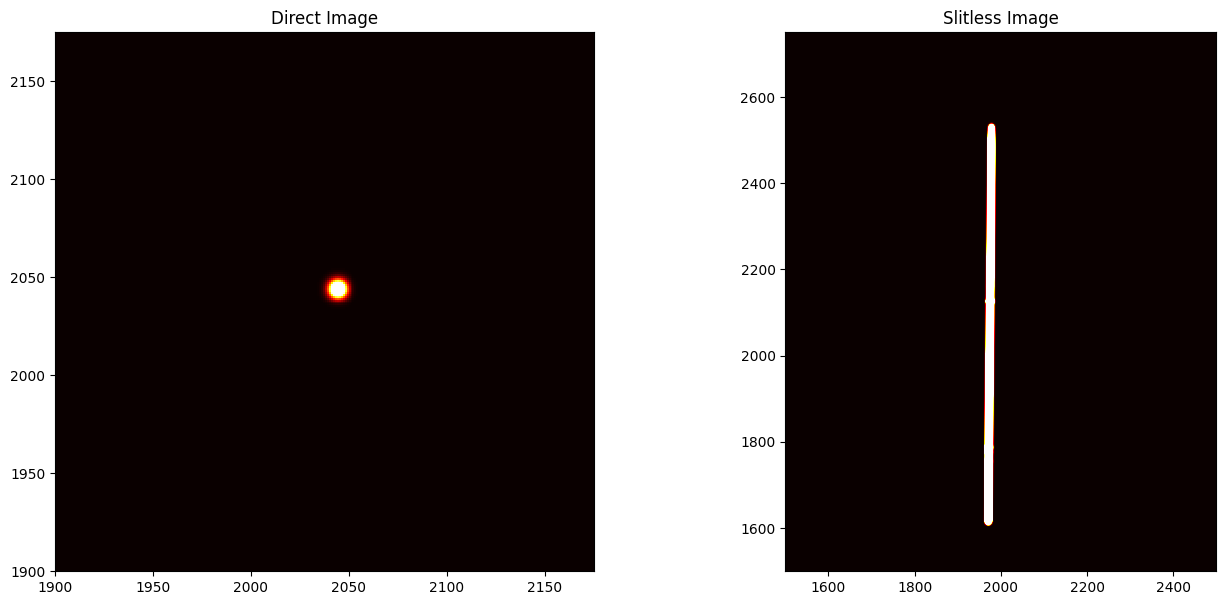

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

upright_direct = np.rot90(roman_sim.direct.data["SCI"])
upright_slitless = np.rot90(roman_sim.model[pad:-pad, pad:-pad])

ax1.imshow(upright_direct, origin='lower', cmap='hot', vmin=0, vmax=5)
ax1.set_title("Direct Image")
ax2.imshow(upright_slitless, origin='lower', cmap='hot', vmin=0, vmax=5)
ax2.set_title("Slitless Image")

ax1.set_xlim(1900, 2175)
ax1.set_ylim(1900, 2175)

ax2.set_xlim(1500, 2500)
ax2.set_ylim(1500, 2750)

In [7]:
max = upright_slitless.max()


print(f"mag: {mag}", 
      f"Spec Temp: {SPECTEMP}",
      f"amplitude: {amplitude}", 
      f"(x/y)_stddev: {x_stddev, y_stddev}", 
      f"max: {max}", 
      sep="\n")

mag: 10
Spec Temp: 4
amplitude: 10
(x/y)_stddev: (30, 30)
max: 3086.765625


# Markdown Cell for storing results

| Num | mag | spec temp | amplitude | (x/y) stddev |   max   | Interest |
|:---:|:---:| :-------: | :-------: | :----------: |  :---:  | :------: |
|  1  | 10  |    4      |    10     |     3, 3     |  3086.8 | Baseline |
|  2  | 20  |    4      |    10     |     3, 3     | 0.30868 |   Mag    |
|  3  | 10  |    4      |    20     |     3, 3     |  3086.8 |          |
|  4  | 10  |    4      |    10     |    30, 30    |  124.98 |   Area   |
|  5  | 10  |    4      |    10     |     3, 3     |  3086.8 | See Note |


## Quantitative notes
5) Used seg map with 10x stddev in both directions (3, 3 for direct object; 30, 30 for seg map). Produced the same slitless image.